In [1]:
# python native
import os
import json
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/conda_envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/ephemeral/conda_envs/torch/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 확인하고 싶은 output csv 경로 및 test 이미지 경로 지정하기
output_dir='/data/ephemeral/home/Seungcheol/code/fcn_resnet50_output.csv'
image_root='../../data/test/DCM'

# 몇번째 테스트 이미지를 보고 싶은지 확인하기
idx=0

In [3]:
df=pd.read_csv(output_dir)
df.head(5)

,image_name,class,rle
0,image1661319116107.png,finger-1,1970702 1 1972749 3 1974795 6 1976842 9 197888...
1,image1661319116107.png,finger-2,2132526 5 2134574 6 2136621 8 2138669 8 214071...
2,image1661319116107.png,finger-3,2587246 2 2589288 11 2591331 17 2593375 22 259...
3,image1661319116107.png,finger-4,NaN
4,image1661319116107.png,finger-5,1209074 1 1211122 1 1213170 2 1215218 2 121726...


In [4]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)



def find_image_path(image_root, image_name):
    # image_root 안의 모든 하위 디렉토리를 순회하며 파일 탐색
    for root, dirs, files in os.walk(image_root):
        if image_name in files:
            return os.path.join(root, image_name)
    # 파일을 찾지 못한 경우 None 반환
    return None

In [5]:
image_name=df['image_name'][idx]
image = cv2.imread(find_image_path(image_root, image_name))

preds = []
for rle in df[df['image_name']==image_name]['rle']:
    if not rle or pd.isna(rle):  # NaN이거나 None인 경우 건너뛰기
        continue
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

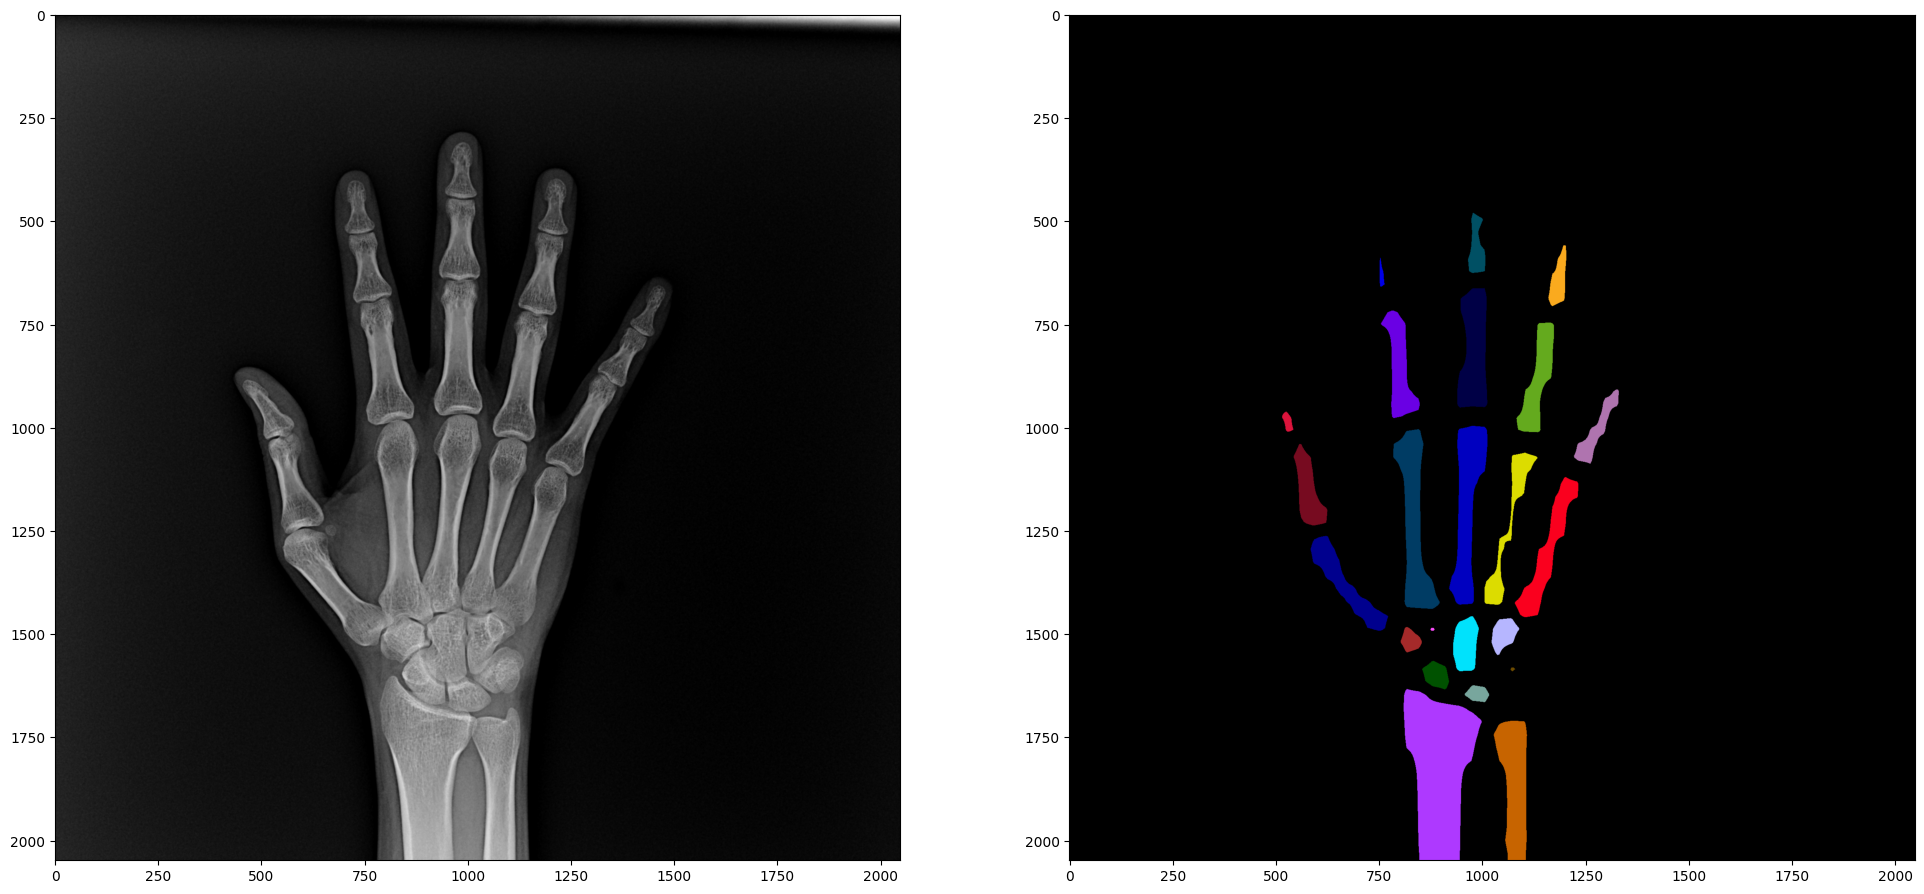

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()